# 1. Loading and cleaning the data

In [1]:
import pandas as pd
import re
df = pd.read_csv('twitter_alcx_data_raw.csv')

In [2]:
df = df.drop_duplicates('id')

In [3]:
df.loc[:, 'content'] = df['content'].apply(lambda x: re.sub(r'http\S+', '', x).strip())

In [4]:
df = df[df['content'].astype(bool) == True].reset_index(drop=True)

In [5]:
len(df)

10882

#### Scams

In [6]:
scams = df[df['content'].str.contains('giveaway|airdrop for free|#airdropcrypto|(Alchemix|ALCX)( token)? Airdrop|Cheat Referral|Minimum Redeem Only|Airdrop bot|Per referral', flags=re.IGNORECASE)]
print(f"Scam tweets: {len(scams)}")
print(f"Scam tweets %age: {len(scams) / len(df) * 100}")

/home/ben/.local/lib/python3.9/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Scam tweets: 226
Scam tweets %age: 2.0768241132144825


#### Foreign language tweets

In [7]:
import langdetect

def detect_language(sentence):
    try:
        return langdetect.detect(sentence)
    except langdetect.lang_detect_exception.LangDetectException:
        return 'n/a'

languages = df['content'].apply(detect_language)

In [8]:
languages.value_counts()

en       8878
de        404
pt        234
es        173
ja        136
it        130
ca        125
tr        116
tl        113
nl         84
fr         62
so         50
ro         47
cy         39
fi         35
et         31
no         28
af         28
id         21
sl         17
da         17
sv         16
sw         15
lv         10
hr          9
hu          9
vi          8
pl          7
sk          7
zh-cn       6
ar          5
ru          5
cs          4
n/a         3
sq          3
lt          2
th          1
fa          1
bn          1
ur          1
bg          1
Name: content, dtype: int64

In [9]:
major_languages = languages.value_counts()[languages.value_counts() >= 50].append(pd.Series([sum(languages.value_counts()[languages.value_counts() < 50])], index=['others'])).sort_values()

array([<AxesSubplot:>], dtype=object)

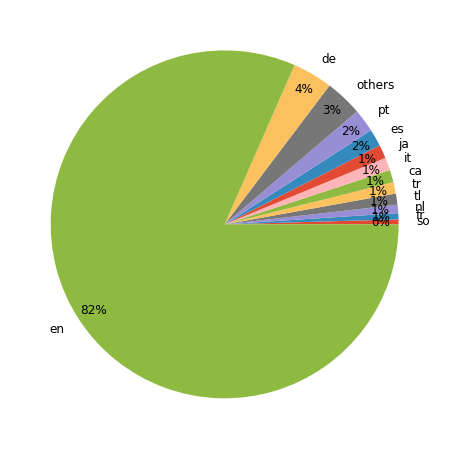

In [322]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
major_languages.plot.pie(subplots=True, figsize=(10, 8), autopct='%1.0f%%', pctdistance=0.9, ylabel='', fontsize=12)

# 2. Mentions, hashtags & tickers

In [11]:
from collections import Counter
def plot_frequency_by_regex(regexp):
    hashtags = [item.capitalize() for sublist in df['content'].apply(lambda x: re.findall(regexp, x)).to_list() for item in sublist]
    tags, counts = zip(*(Counter(hashtags).most_common(15)))
    pd.DataFrame(counts, index=tags).sort_values(0).plot.barh(legend=False, figsize=(5,5), fontsize=12)

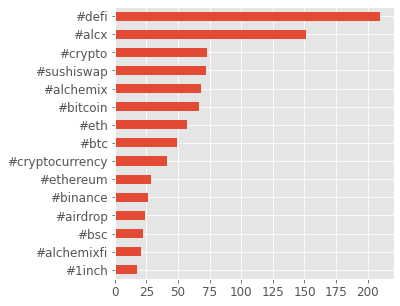

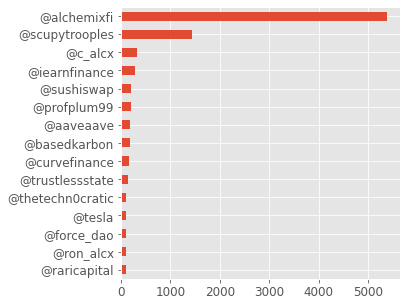

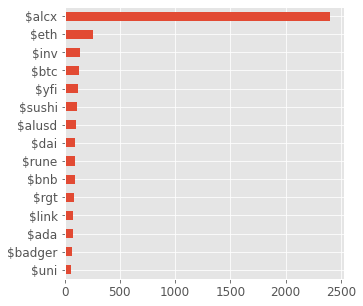

In [253]:
HASHTAG_REGEX = r"#\w+"
MENTION_REGEX = r"@\w+"
TICKER_REGEX = r'\s(\$[A-z-0-9][A-z]+)\b'
REGEXES = [HASHTAG_REGEX, MENTION_REGEX, TICKER_REGEX]
for regexp in REGEXES:
    plot_frequency_by_regex(regexp)

# 3. Time charts

We'll get the hourly price data from Flipside.

Both Flipside & Twitter timestamp are in UTC so no timezone conversion headache.

In [339]:
import requests
import json
r = requests.get('https://api.flipsidecrypto.com/api/v2/queries/987764dc-d48d-4dfd-b345-b21f59740a3c/data/latest')
price_df = pd.DataFrame(json.loads(r.content.decode('utf8')))
price_df['HOUR'] = price_df['HOUR'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
price_df.head()

,HOUR,PRICE,SYMBOL
0,2021-04-11 17:00:00+00:00,1927.511067,ALCX
1,2021-04-11 16:00:00+00:00,1927.339762,ALCX
2,2021-04-11 15:00:00+00:00,1922.083891,ALCX
3,2021-04-11 14:00:00+00:00,1916.192254,ALCX
4,2021-04-11 13:00:00+00:00,1912.819286,ALCX


We'll split days in 6 hour periods as there's not enough discourse volume to justify higher granularity

In [14]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))

In [15]:
day_quarters_tweets = df.copy()
day_quarters_tweets['date'] = day_quarters_tweets['date'].dt.round('6h')

In [44]:
day_quarters_prices = price_df.copy()
day_quarters_prices['HOUR'] = day_quarters_prices['HOUR'].dt.round('6h')
day_quarters_prices = day_quarters_prices.groupby('HOUR').mean()

In [17]:
tweets_vs_price_df = pd.DataFrame(day_quarters_tweets['date'].value_counts()).join(day_quarters_prices, how='outer')
tweets_vs_price_df.columns = ['Tweets', 'Price']

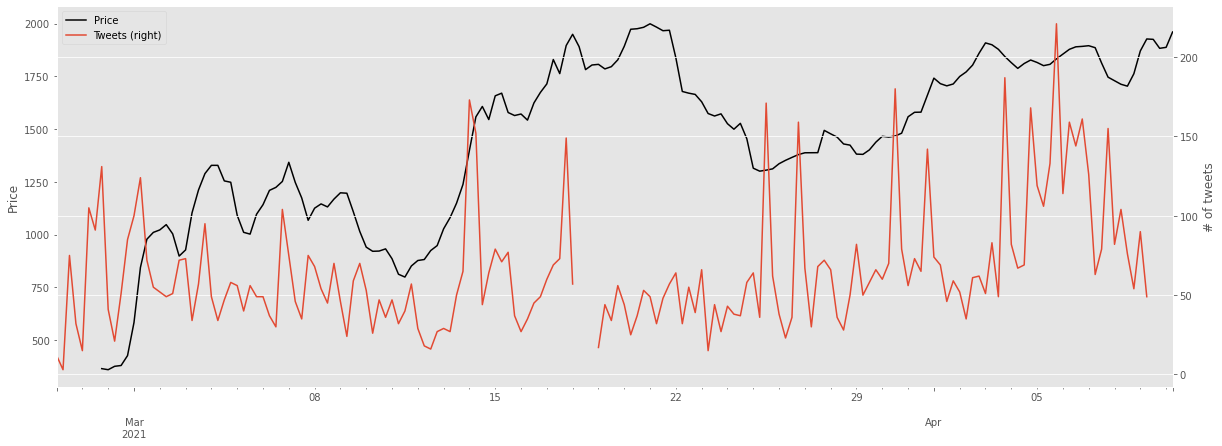

In [42]:
plt.style.use('ggplot')
ax = tweets_vs_price_df.plot(y='Price', color='k')
ax.set_ylabel('Price')
ax2 = tweets_vs_price_df.plot(y='Tweets', ax=ax, secondary_y=True, figsize=(20,7))
ax2.set_ylabel('# of tweets')
plt.show()

In [22]:
tweets_vs_price_df_no_na = tweets_vs_price_df.dropna()

In [35]:
import scipy
scipy.stats.pearsonr(tweets_vs_price_df_no_na['Tweets'], tweets_vs_price_df_no_na['Price'])

(0.2244385835125994, 0.004328389975303516)

Let's test which way the correlation goes with a Granger test (assume stationarity which is wrong but will do for now)

In [32]:
import statsmodels

statsmodels.tsa.stattools.grangercausalitytests(tweets_vs_price_df_no_na, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4712  , p=0.0643  , df_denom=156, df_num=1
ssr based chi2 test:   chi2=3.5379  , p=0.0600  , df=1
likelihood ratio test: chi2=3.4991  , p=0.0614  , df=1
parameter F test:         F=3.4712  , p=0.0643  , df_denom=156, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9388  , p=0.3933  , df_denom=153, df_num=2
ssr based chi2 test:   chi2=1.9390  , p=0.3793  , df=2
likelihood ratio test: chi2=1.9272  , p=0.3815  , df=2
parameter F test:         F=0.9388  , p=0.3933  , df_denom=153, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2925  , p=0.8308  , df_denom=150, df_num=3
ssr based chi2 test:   chi2=0.9184  , p=0.8210  , df=3
likelihood ratio test: chi2=0.9157  , p=0.8216  , df=3
parameter F test:         F=0.2925  , p=0.8308  , df_denom=150, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0897  , p=0.9855  

{1: ({'ssr_ftest': (3.4711620694117693, 0.06432752074365984, 156.0, 1),
   'ssr_chi2test': (3.537915186131226, 0.059980807987444186, 1),
   'lrtest': (3.499128352410935, 0.06140113812471106, 1),
   'params_ftest': (3.471162069411688, 0.06432752074366391, 156.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.9388329317795514, 0.3933250920368564, 153.0, 2),
   'ssr_chi2test': (1.939027493087178, 0.3792674133638645, 2),
   'lrtest': (1.927225762766966, 0.3815120353223228, 2),
   'params_ftest': (0.9388329317795545, 0.3933250920368564, 153.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.2924881454034118, 0.8307780393556382, 150.0, 3),
   'ssr_chi2test': (0.918412776566713, 0.8209822617557545, 3),
   'lrtest': (0.9157369582667343, 0.8216285536770865, 3),
   'params_ftest': (0.2924881454033132, 0.830778039355707, 150.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.

In [83]:
statsmodels.tsa.stattools.grangercausalitytests(tweets_vs_price_df_no_na.reindex(columns=['Price', 'Tweets']), maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4245  , p=0.0122  , df_denom=156, df_num=1
ssr based chi2 test:   chi2=6.5480  , p=0.0105  , df=1
likelihood ratio test: chi2=6.4168  , p=0.0113  , df=1
parameter F test:         F=6.4245  , p=0.0122  , df_denom=156, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1151  , p=0.0472  , df_denom=153, df_num=2
ssr based chi2 test:   chi2=6.4338  , p=0.0401  , df=2
likelihood ratio test: chi2=6.3063  , p=0.0427  , df=2
parameter F test:         F=3.1151  , p=0.0472  , df_denom=153, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9415  , p=0.1253  , df_denom=150, df_num=3
ssr based chi2 test:   chi2=6.0965  , p=0.1070  , df=3
likelihood ratio test: chi2=5.9811  , p=0.1125  , df=3
parameter F test:         F=1.9415  , p=0.1253  , df_denom=150, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4301  , p=0.2269  

{1: ({'ssr_ftest': (6.424474294727875, 0.012240949954838945, 156.0, 1),
   'ssr_chi2test': (6.548021877318796, 0.010500083342405382, 1),
   'lrtest': (6.416780952472891, 0.011304689452259195, 1),
   'params_ftest': (6.4244742947256785, 0.012240949954853331, 156.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.115105598124648, 0.04720042572408204, 153.0, 2),
   'ssr_chi2test': (6.433812869329338, 0.04007885322904366, 2),
   'lrtest': (6.306270247879866, 0.042717990515135175, 2),
   'params_ftest': (3.1151055981244986, 0.047200425724088904, 153.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.941544608373624, 0.12533041177013815, 150.0, 3),
   'ssr_chi2test': (6.09645007029318, 0.10701085642201116, 3),
   'lrtest': (5.981062373531358, 0.11253522565373067, 3),
   'params_ftest': (1.9415446083736787, 0.12533041177012988, 150.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

Granger causality tests are insignifcant for Tweets on Price, however changes in price are a predictor of twitter discourse volume.

In [82]:
tweets_vs_price_df_no_na.reindex(columns=['Price', 'Tweets'])

,Price,Tweets
2021-02-27 18:00:00+00:00,364.100191,131.0
2021-02-28 00:00:00+00:00,359.064441,41.0
2021-02-28 06:00:00+00:00,375.170181,21.0
2021-02-28 12:00:00+00:00,378.971877,51.0
2021-02-28 18:00:00+00:00,425.908233,85.0
...,...,...
2021-04-08 06:00:00+00:00,1712.985867,104.0
2021-04-08 12:00:00+00:00,1704.001213,76.0
2021-04-08 18:00:00+00:00,1762.931008,54.0
2021-04-09 00:00:00+00:00,1871.067271,90.0


Text(0.5, 0, 'Lag')

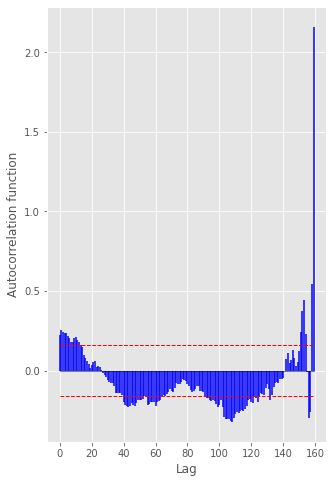

In [34]:
import numpy as np

tweets = np.array(tweets_vs_price_df_no_na['Tweets'])
price = np.array(tweets_vs_price_df_no_na['Price'])
lags= price.shape[0]
sl = 2 / np.sqrt(lags)

plt.subplots(figsize=(5,8))
plt.plot(list(np.ones(lags) * sl), color='r', linewidth=1, linestyle='dashed')
plt.plot(list(np.ones(lags) * -sl), color='r', linewidth=1, linestyle='dashed')
plt.plot([0]*lags, color='black', linewidth=0.5)

for i, value in enumerate(statsmodels.tsa.stattools.ccf(price, tweets)[:lags]):
    plt.vlines(i, ymax=value, ymin=0, color = 'b')
plt.ylabel("Autocorrelation function")
plt.xlabel("Lag")

#### Did any tweet start a massive sell-off / buy ?

We'll look at the largest hourly variation and then at the tweet made in the hour preceding the large variation.

In [68]:
hourly_price_variations = pd.DataFrame(price_df.set_index('HOUR')['PRICE'].pct_change(1).dropna().sort_values()).reset_index()

In [78]:
moon_tweets = df[(df['date'].between("2021-03-24 18:00:00", "2021-03-24 19:00:00"))][['content', 'user']]

with option_context('display.max_colwidth', 400):
    display(moon_tweets)

,content,user
4244,@defichadventure @AlchemixFi True chads,thelionshire
4245,@defichadventure @AlchemixFi wow what a bunch of nerds,TheCryptoDog
4246,@defichadventure @AlchemixFi lmao this is fucking beautiful,transmissions11
4247,@defichadventure @AlchemixFi certified chads up in there,thetechn0cratic
4248,@AlchemixFi and the pseudo anonymous team doing the lords work. Making money make sense for the first time in human history!!!,theDESK9
4249,"@JKrantz @Substreight @AlchemixFi @Tesla It's over collateralized (2x), but also pays itself using interest from yearn dai vault currently.",bitcoin4bernie
4250,@defichadventure @AlchemixFi,J1998Madden
4251,@PrestonPysh @BlockFiZac @elonmusk @AlchemixFi is already doing this,FinancePursuits
8529,few\n$alcx $wasabi,BlueSaunaRobe


https://twitter.com/defichadventure/status/1374782668915814401

In [75]:
from pandas import option_context
dump_tweets = df[(df['date'].between("2021-03-01 03:00:00+00:00", "2021-03-01 04:00:00+00:00"))][['content', 'user']]

with option_context('display.max_colwidth', 400):
    display(dump_tweets)

,content,user
1443,"🥳10,000 USDT To Be Won! @alchemixfi\n\n Will List $ALCX(Alchemix ) on March 1🚀🚀\n\n🌟Trading starts: 11:30 on March 1, 2021 (UTC+8)\n🌟Deposit: Enabled\n🌟Withdrawal: 10:00 on March 2 (UTC+8)\n\n🎉Details:",Hoo_exchange
1444,@econoar No body make the price go up. I gotta unwind my Alchemix farm,josephdelong
6207,@Naty_Airmuze @AlchemixFi Tu si que sabes!!,nbdhps
6208,$ALCX @AlchemixFi smashing it!,Cryptonomatron
6209,@CryptoBalo @UncleRewards @antiprosynth @AlchemixFi Seems like protocols are relying on yearn for their yield if the trend continues yearn AUM get fat... not just b/c of individuals seeking yield but protocols &amp; their treasuries depending on it,0xGlibGlob
6210,@AlchemixFi I had to post it here. All of your channels are read-only.,BelloStakeOps
6211,@AlchemixFi Trying to stake..,BelloStakeOps
6212,@AlchemixFi What are the gas parameters? I am getting a huge fee in meta mask.,BelloStakeOps
6213,Get in there. The next big thing you haven't heard about yet.\n\ninb4 Yearn ecosystem integration 😉\n\n$ALCX\n@AlchemixFi,rastascrypto
6214,"@SCryptoschool @AlchemixFi @AlchemixFi is here to bring us Competitive high yield strategies, w/ no Liquidation Risk plus low maintenance on its advance yield features. They really got what it is to be a future yield backed synthetic asset platform. @SCryptoschool #SmartLiquidity",MaryAprilAlfor1


# 3. Keywords and themes

## 3.1. Preprocessing

In [117]:
import unidecode
import unicodedata
import spacy
nlp = spacy.load("en_core_web_sm")

In [128]:
english_df = df[languages == 'en'].copy()

In [132]:
# removing mentions
removed_mentions = english_df['content'].apply(lambda x: re.sub(MENTION_REGEX + '|#|\$', '', x))

# normalizing punctuation
def standardize_punctuation(text):
    return ''.join([unidecode.unidecode(t) if unicodedata.category(t)[0] == 'P' else t for t in text])

english_df.loc[:, 'content'] = removed_mentions.apply(standardize_punctuation)
english_df

,date,id,content,user
0,2021-04-09 08:06:03+00:00,1380431804029603840,"Twitter should pay us for using it, just li...",EthZig
1,2021-04-09 07:30:20+00:00,1380422812364640257,You want to tell us that Spartan Lending will...,jpalaeno
2,2021-04-09 07:03:21+00:00,1380416024437137409,Alchemix right now isn't a great hedging too...,scupytrooples
3,2021-04-09 05:14:22+00:00,1380388598642450432,Alchemix --&gt; People find it very hard to ...,ali1sheikh
4,2021-04-09 04:28:15+00:00,1380376992445530112,"Alchemix upgrade, ETH as a store of value and ...",frank05851567
...,...,...,...,...
10869,2021-02-26 14:40:39+00:00,1365310818271772679,"Cheers Chris. Heya, I'm available on the day...",PhotoSonny
10870,2021-02-26 14:28:44+00:00,1365307818593648642,ALCX Discord is basically the top 100 Degen Sc...,0xGav
10872,2021-02-26 10:05:05+00:00,1365241466092683264,Oh I love that,jellycrone
10873,2021-02-26 09:42:09+00:00,1365235697158922240,We also have these which are nice for glowy v...,ifancykitkat


In [141]:
def lemmatize_and_remove_stopwords(sentence):
    doc = nlp(sentence)
    lemmatized = [token.lemma_ for token in doc if (not token.is_stop) and token.is_alpha]
    return ' '.join(lemmatized)

english_df['lemmas'] = english_df['content'].apply(lemmatize_and_remove_stopwords)

## 3.2. Word cloud

In [149]:
tokens = ' '.join(english_df['lemmas'].tolist())
tokens = ' '.join([t.capitalize() for t in tokens.split() if t.lower() not in ['alchemix', 'alcx', 'alchemixfi']])

In [150]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(tokens)

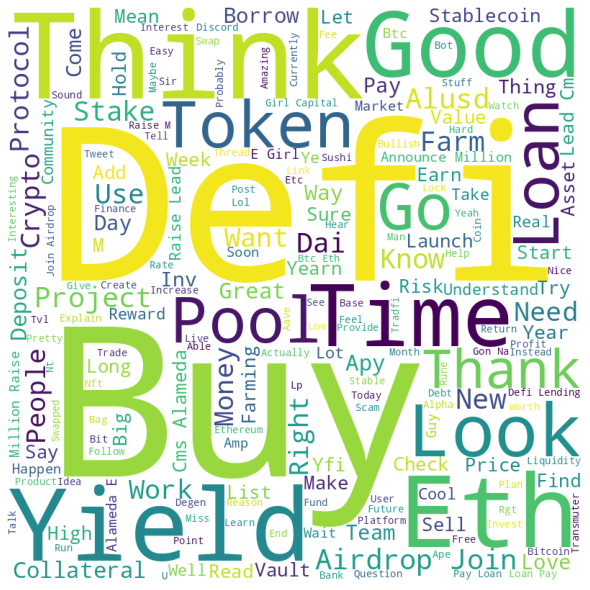

In [151]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# 3.3. Topics

In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
num_topics = 4

vectorizer = TfidfVectorizer(max_df=0.85, min_df=10, max_features=2500)
X = vectorizer.fit_transform(english_df['lemmas'])
nmf = NMF(n_components=num_topics, init = 'nndsvd').fit(X)
display_topics(nmf, vectorizer.get_feature_names(), 15)

Topic 0:
alcx, buy, eth, sushiswap, swapped, inv, stake, pool, referral, farm, go, sushi, ape, price, list
Topic 1:
alchemix, raise, alameda, cms, lead, million, capital, announce, girl, defi, lending, bitcoin, back, protocol, income
Topic 2:
loan, pay, yield, dai, alusd, like, alchemix, defi, deposit, collateral, think, good, use, look, borrow
Topic 3:
airdrop, join, alchemix, defiqa, sfm, kjb, pluto, referral, link, telegram, coins, coin, task, claim, wallet


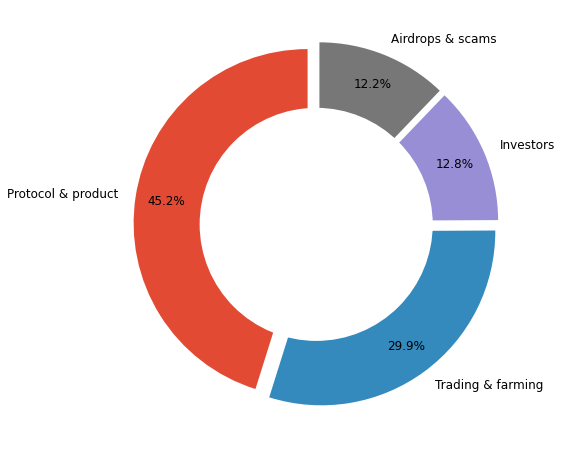

In [323]:
nmf_output = nmf.transform(X)
topic_res = pd.DataFrame(np.round(nmf_output, 2), columns=['Trading & farming', 'Investors', 'Protocol & product', 'Airdrops & scams'], index=english_df.index)

ax=topic_res[topic_res.columns].sum().sort_values(ascending=False).plot.pie(autopct='%1.1f%%', title='', figsize=(8,8), fontsize=12, startangle=90, pctdistance=0.82, explode=len(topic_res.columns)*[0.05])
ax.set_ylabel('')
centre_circle = plt.Circle((0,0),0.67,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# 4. Sentiment analysis

Let's first try with a generic BERT-based model and see how it performs.

In [171]:
import torch
from transformers import AutoTokenizer, AutoConfig
import torch.nn as nn
from transformers import BertPreTrainedModel

class BertForSentimentClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.cls_layer = nn.Linear(config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_reps = outputs.last_hidden_state[:, 0]
        logits = self.cls_layer(cls_reps)
        return logits

In [173]:
model = BertForSentimentClassification.from_pretrained('barissayil/bert-sentiment-analysis-sst')
tokenizer = AutoTokenizer.from_pretrained('barissayil/bert-sentiment-analysis-sst')

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

In [174]:
def classify_sentiment(sentence):
    with torch.no_grad():
        tokens = tokenizer.tokenize(sentence)
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_ids = torch.tensor(input_ids)
        input_ids = input_ids.unsqueeze(0)
        attention_mask = (input_ids != 0).long()
        logit = model(input_ids=input_ids, attention_mask=attention_mask)
        prob = torch.sigmoid(logit.unsqueeze(-1))
        prob = prob.item()
        return (2 * prob) - 1 # scale probability to [-1, 1] range

In [193]:
english_df['sentiment'] = english_df['content'].apply(classify_sentiment)

In [198]:
with option_context('display.max_colwidth', 400):
    display(english_df[['content', 'sentiment']].sample(10))

,content,sentiment
3073,Will AlchemixFi make it's way to the Cardano ecosystem and deploy on Alonzo testnet?,-0.530867
7057,Not only in it for the money.. \n\nIn it for the banked the unbanked revolution!! \n\nETH ALCX SUSHI BNB,0.000150
2817,K I guess that's 6,0.064948
5425,"that's a great opener... now, heads back down and Buidl",0.687502
1028,When it comes to DeFi partnerships and Alchemix:,0.203041
644,OH MY GOSH I'LL USE ALCHEMIX TO PAY MY TAXES. I'M A GENIUS!\nTHANK YOU !!\n\nThis protocol is such a life hack!,-0.523767
8731,Snagged some ALCX on this dip. LFG.,-0.930640
3793,"4) Now this is where the fun reallyrstarts. In a bull market, is great but in a Bear market its true magic comes out. Imagine you've taken profits or escaped into stable coins. You might be getting a yield on them but why wouldn't you max out that leverage?",-0.106745
8261,No but has an auto compounding alcx vault,-0.692804
443,"Flipside is an awesome data analytics tool for Ethereum, similar to Dune Analytics. What sets them apart is the ability to call the data via an api to embed it in your site. Very cool stuff.",0.977803


In [200]:
english_df['sentiment'].mean()

-0.1262774095887024

This is terrible. Sentiment models are typically biased towards positive. Better try with a model trained on Twitter data (this one is trained on Stanford Treebank) 

In [207]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
labels = ['negative', 'neutral', 'positive']

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [251]:
from scipy.special import softmax
def get_sentiments(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return dict(zip(labels, scores))

In [252]:
sentiments = english_df['content'].apply(get_sentiments)

In [255]:
sentiments_df = pd.DataFrame(sentiments.tolist())

<AxesSubplot:>

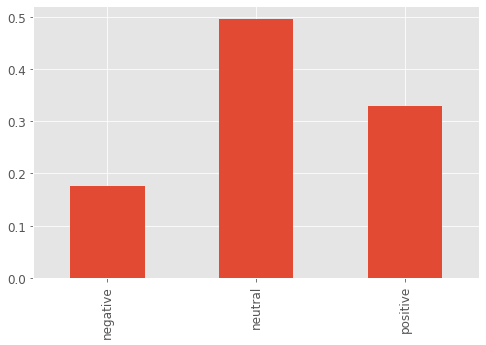

In [263]:
sentiments_df.mean().plot.bar(figsize=(8,5), fontsize=12)

In [273]:
rated_content_df = pd.concat([english_df[['date', 'content']].reset_index(drop=True), sentiments_df.reset_index(drop=True)], axis=1)
rated_content_df['score'] = rated_content_df['positive'] - rated_content_df['negative']
rated_content_df

,date,content,negative,neutral,positive,score
0,2021-04-09 08:06:03+00:00,"Twitter should pay us for using it, just li...",0.091359,0.573735,0.334907,0.243548
1,2021-04-09 07:30:20+00:00,You want to tell us that Spartan Lending will...,0.111926,0.645872,0.242202,0.130277
2,2021-04-09 07:03:21+00:00,Alchemix right now isn't a great hedging too...,0.326053,0.484035,0.189912,-0.136140
3,2021-04-09 05:14:22+00:00,Alchemix --&gt; People find it very hard to ...,0.385970,0.508825,0.105205,-0.280766
4,2021-04-09 04:28:15+00:00,"Alchemix upgrade, ETH as a store of value and ...",0.006945,0.720106,0.272949,0.266004
...,...,...,...,...,...,...
8873,2021-02-26 14:40:39+00:00,"Cheers Chris. Heya, I'm available on the day...",0.003905,0.307505,0.688590,0.684685
8874,2021-02-26 14:28:44+00:00,ALCX Discord is basically the top 100 Degen Sc...,0.020311,0.537256,0.442433,0.422122
8875,2021-02-26 10:05:05+00:00,Oh I love that,0.004317,0.018548,0.977136,0.972819
8876,2021-02-26 09:42:09+00:00,We also have these which are nice for glowy v...,0.000881,0.042189,0.956930,0.956049


In [275]:
rated_content_df['score'].mean()

0.15248932158635173

Text(0.5, 0, 'Sentiment score')

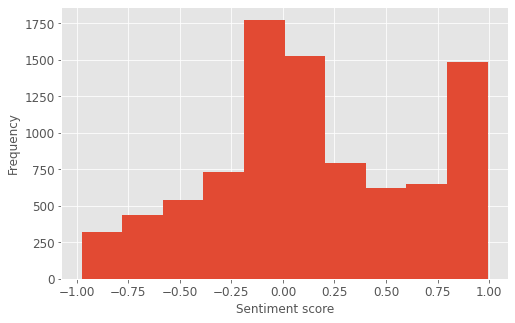

In [328]:
ax = rated_content_df['score'].plot.hist(figsize=(8,5), fontsize=12)
ax.set_xlabel("Sentiment score")

#### Bearish tweets

In [319]:
rated_content_df.sort_values('score').reset_index().loc[:9, ['content', 'score']]

,content,score
0,I waste my time for that... fuck,-0.975216
1,i hate you,-0.973709
2,Damn you shit heads are rude,-0.971691
3,Yo ALCX I just bought this fucking GARBAGE tod...,-0.971330
4,wow you guys really don't understand alchemix...,-0.966307
5,"thats a fucking SCAM, idiot. \n\nALCHEMIX H...",-0.966076
6,Because of that horrible Curve website I...,-0.961155
7,my ALCX position if flipping between +500 and ...,-0.956623
8,AUTO is undervalued as fuck,-0.956382
9,I'd probs be very annoyed by them IRL\n\nalso...,-0.956151


#### Bullish tweets

In [318]:
rated_content_df.sort_values('score').reset_index().loc[len(rated_content_df)-10:, ['content', 'score']]

,content,score
8868,Very happy about my entry in Alchemix of 2 day...,0.991038
8869,Will be my first time using the app. Excited!,0.991294
8870,This is such a great project. HYPED ALCX,0.991304
8871,"Great project, bright future. Congrats to the ...",0.991313
8872,Very exciting times. Really enjoying what this...,0.991383
8873,awesome to see ALCX doing so well. congrats ...,0.991444
8874,Love the aesthetic of its so beautiful I am e...,0.991502
8875,"That's amazing! Loving these new ""advance fo...",0.991535
8876,Look at this beauty.... The app is insanely ea...,0.991919
8877,Super excited about your project! Have been i...,0.992044


In [330]:
print(rated_content_df.sort_values('score').reset_index().loc[:9, ['content', 'score']].to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>content</th>
      <th>score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>I waste my time for that... fuck</td>
      <td>-0.975216</td>
    </tr>
    <tr>
      <th>1</th>
      <td>i hate you</td>
      <td>-0.973709</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Damn you shit heads are rude</td>
      <td>-0.971691</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Yo ALCX I just bought this fucking GARBAGE today when the FUCK is that BAG getting dropped off!?  ETH cryptocurrency TiredoftheBullshit</td>
      <td>-0.971330</td>
    </tr>
    <tr>
      <th>4</th>
      <td>wow you guys really don't understand alchemix and i would expect more from y'all</td>
      <td>-0.966307</td>
    </tr>
    <tr>
      <th>5</th>
      <td>thats a fucking SCAM, idiot. \n\nALCHEMIX HAVE NO AIRDROP!!!</td>
      <td>-0.966076</td>
    </tr>
    <tr>
      <th>

#### Plotting sentiment against price

In [295]:
day_quarters_sentiment = rated_content_df.copy()
day_quarters_sentiment['date'] = day_quarters_sentiment['date'].dt.round('6h')
sentiment_vs_price_df = pd.DataFrame(day_quarters_sentiment.groupby(['date']).mean()[['score']].join(day_quarters_prices, how='outer'))
sentiment_vs_price_df.columns = ['Sentiment', 'Price']

In [294]:
day_quarters_sentiment = rated_content_df.copy()
day_quarters_sentiment['date'] = day_quarters_sentiment['date'].dt.round('6h')
day_quarters_sentiment.groupby(['date']).mean()[['score']]

,score
date,
2021-02-26 00:00:00+00:00,0.204177
2021-02-26 06:00:00+00:00,0.861557
2021-02-26 12:00:00+00:00,-0.048065
2021-02-26 18:00:00+00:00,-0.097910
2021-02-27 00:00:00+00:00,0.224265
...,...
2021-04-08 06:00:00+00:00,0.076590
2021-04-08 12:00:00+00:00,0.189420
2021-04-08 18:00:00+00:00,-0.018558


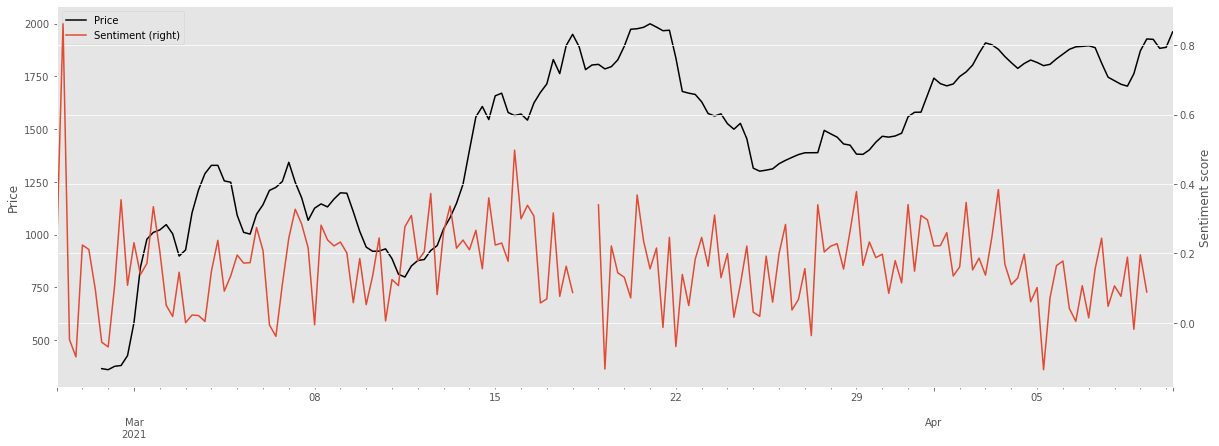

In [296]:
plt.style.use('ggplot')
ax = sentiment_vs_price_df.plot(y='Price', color='k')
ax.set_ylabel('Price')
ax2 = sentiment_vs_price_df.plot(y='Sentiment', ax=ax, secondary_y=True, figsize=(20,7))
ax2.set_ylabel('Sentiment score')
plt.show()

In [297]:
sentiment_vs_price_df_no_na = sentiment_vs_price_df.dropna()

In [298]:
scipy.stats.pearsonr(sentiment_vs_price_df_no_na['Sentiment'], sentiment_vs_price_df_no_na['Price'])

(0.013701272083313232, 0.8634704632289188)

In [301]:
statsmodels.tsa.stattools.grangercausalitytests(sentiment_vs_price_df_no_na, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1499  , p=0.6992  , df_denom=156, df_num=1
ssr based chi2 test:   chi2=0.1527  , p=0.6959  , df=1
likelihood ratio test: chi2=0.1527  , p=0.6960  , df=1
parameter F test:         F=0.1499  , p=0.6992  , df_denom=156, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3247  , p=0.2689  , df_denom=153, df_num=2
ssr based chi2 test:   chi2=2.7360  , p=0.2546  , df=2
likelihood ratio test: chi2=2.7126  , p=0.2576  , df=2
parameter F test:         F=1.3247  , p=0.2689  , df_denom=153, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9725  , p=0.4075  , df_denom=150, df_num=3
ssr based chi2 test:   chi2=3.0536  , p=0.3834  , df=3
likelihood ratio test: chi2=3.0243  , p=0.3879  , df=3
parameter F test:         F=0.9725  , p=0.4075  , df_denom=150, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5176  , p=0.7229  

{1: ({'ssr_ftest': (0.1498593912151344, 0.6991973654693713, 156.0, 1),
   'ssr_chi2test': (0.1527413025846562, 0.6959293162672249, 1),
   'lrtest': (0.1526679850524033, 0.6959986640202674, 1),
   'params_ftest': (0.149859391215188, 0.6991973654693215, 156.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.3246945075992274, 0.2689161028037295, 153.0, 2),
   'ssr_chi2test': (2.735970355564417, 0.2546194560218652, 2),
   'lrtest': (2.71255191758587, 0.25761837422231115, 2),
   'params_ftest': (1.324694507596139, 0.2689161028045476, 153.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.9724770153164427, 0.407459109557321, 150.0, 3),
   'ssr_chi2test': (3.0535778280936303, 0.38343807120724216, 3),
   'lrtest': (3.0242619954320844, 0.3878995595344867, 3),
   'params_ftest': (0.9724770153157806, 0.407459109557628, 150.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0

In [302]:
statsmodels.tsa.stattools.grangercausalitytests(sentiment_vs_price_df_no_na.reindex(columns=['Price', 'Sentiment']), maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2154  , p=0.6432  , df_denom=156, df_num=1
ssr based chi2 test:   chi2=0.2195  , p=0.6394  , df=1
likelihood ratio test: chi2=0.2194  , p=0.6395  , df=1
parameter F test:         F=0.2154  , p=0.6432  , df_denom=156, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2364  , p=0.7898  , df_denom=153, df_num=2
ssr based chi2 test:   chi2=0.4882  , p=0.7834  , df=2
likelihood ratio test: chi2=0.4874  , p=0.7837  , df=2
parameter F test:         F=0.2364  , p=0.7898  , df_denom=153, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5623  , p=0.6407  , df_denom=150, df_num=3
ssr based chi2 test:   chi2=1.7656  , p=0.6225  , df=3
likelihood ratio test: chi2=1.7557  , p=0.6246  , df=3
parameter F test:         F=0.5623  , p=0.6407  , df_denom=150, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5582  , p=0.6933  

{1: ({'ssr_ftest': (0.21536752761470956, 0.6432394732943207, 156.0, 1),
   'ssr_chi2test': (0.21950921083806937, 0.6394141297675903, 1),
   'lrtest': (0.21935782721539, 0.6395296579923893, 1),
   'params_ftest': (0.21536752761471809, 0.6432394732943207, 156.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.23636063513728117, 0.7897836388009093, 153.0, 2),
   'ssr_chi2test': (0.48816967779987486, 0.7834211668534079, 2),
   'lrtest': (0.487417083174023, 0.7837160216064305, 2),
   'params_ftest': (0.23636063513722472, 0.7897836388009496, 153.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.5622850232076029, 0.6407173252920256, 150.0, 3),
   'ssr_chi2test': (1.765574972871873, 0.6224547034287198, 3),
   'lrtest': (1.7557212153440105, 0.6246175620912842, 3),
   'params_ftest': (0.5622850232076196, 0.6407173252920182, 150.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

# 5. Other metrics

## 5.1. TVL

In [387]:
r = requests.get('https://api.flipsidecrypto.com/api/v2/queries/c547e1a0-5869-46cd-8beb-945d6a2e254a/data/latest')
tvl_df = pd.DataFrame(json.loads(r.content.decode('utf8')))
tvl_df['METRIC_DATE'] = tvl_df['METRIC_DATE'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
tvl_df.head()

,LABEL,METRIC_DATE,TVL
0,alUSD3CRV,2021-04-11 00:00:00+00:00,3.870100e+08
1,alUSD,2021-04-11 00:00:00+00:00,4.975290e+07
2,ALCX-ETH SLP,2021-04-11 00:00:00+00:00,3.042411e+08
3,ALCX,2021-04-11 00:00:00+00:00,1.311527e+08
4,alUSD3CRV,2021-04-10 00:00:00+00:00,3.951842e+08


In [389]:
tvl_df = tvl_df.groupby('METRIC_DATE').sum().sort_index()

In [383]:
daily_tweets = df.copy()
daily_tweets['date'] = daily_tweets['date'].dt.round('1d')

In [390]:
tweets_vs_tvl = pd.DataFrame(daily_tweets['date'].value_counts()).join(tvl_df, how='inner').sort_index()

In [393]:
tweets_vs_tvl.columns = ['Tweets', 'TVL']

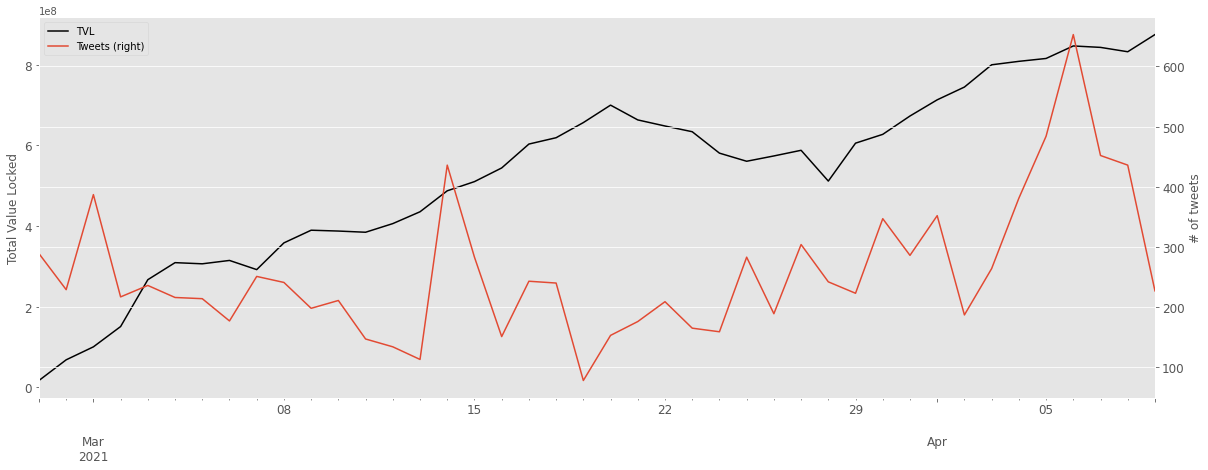

In [395]:
ax = tweets_vs_tvl.plot(y='TVL', color='k')
ax.set_ylabel('Total Value Locked')
ax2 = tweets_vs_tvl.plot(y='Tweets', ax=ax, secondary_y=True, figsize=(20,7), fontsize=12)
ax2.set_ylabel('# of tweets')
plt.show()

In [396]:
scipy.stats.pearsonr(tweets_vs_tvl['TVL'], tweets_vs_tvl['Tweets'])

(0.3102650890677427, 0.04553060873732286)

In [397]:
statsmodels.tsa.stattools.grangercausalitytests(tweets_vs_tvl, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5309  , p=0.2236  , df_denom=38, df_num=1
ssr based chi2 test:   chi2=1.6518  , p=0.1987  , df=1
likelihood ratio test: chi2=1.6194  , p=0.2032  , df=1
parameter F test:         F=1.5309  , p=0.2236  , df_denom=38, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9574  , p=0.3937  , df_denom=35, df_num=2
ssr based chi2 test:   chi2=2.1883  , p=0.3348  , df=2
likelihood ratio test: chi2=2.1305  , p=0.3446  , df=2
parameter F test:         F=0.9574  , p=0.3937  , df_denom=35, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5337  , p=0.2247  , df_denom=32, df_num=3
ssr based chi2 test:   chi2=5.6074  , p=0.1324  , df=3
likelihood ratio test: chi2=5.2392  , p=0.1551  , df=3
parameter F test:         F=1.5337  , p=0.2247  , df_denom=32, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8158  , p=0.5255  , df_d

{1: ({'ssr_ftest': (1.5309165722679015, 0.22356647212650302, 38.0, 1),
   'ssr_chi2test': (1.6517784069206307, 0.19871705315660665, 1),
   'lrtest': (1.6193730666412307, 0.20317922664181856, 1),
   'params_ftest': (1.530916572267762, 0.22356647212652395, 38.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.9573634081094801, 0.3937284043893024, 35.0, 2),
   'ssr_chi2test': (2.188259218535954, 0.33483091387902575, 2),
   'lrtest': (2.130500425924083, 0.34464161017978723, 2),
   'params_ftest': (0.9573634090175873, 0.3937284040503, 35.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.5336605452249785, 0.22470816151205025, 32.0, 3),
   'ssr_chi2test': (5.607446368478828, 0.13235152299592265, 3),
   'lrtest': (5.239227157896494, 0.15509481560916633, 3),
   'params_ftest': (1.5336605455889651, 0.22470816142095068, 32.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 

In [399]:
statsmodels.tsa.stattools.grangercausalitytests(tweets_vs_tvl.reindex(columns=['TVL', 'Tweets']), maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5099  , p=0.4795  , df_denom=38, df_num=1
ssr based chi2 test:   chi2=0.5502  , p=0.4582  , df=1
likelihood ratio test: chi2=0.5465  , p=0.4597  , df=1
parameter F test:         F=0.5099  , p=0.4795  , df_denom=38, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5749  , p=0.0905  , df_denom=35, df_num=2
ssr based chi2 test:   chi2=5.8856  , p=0.0527  , df=2
likelihood ratio test: chi2=5.4909  , p=0.0642  , df=2
parameter F test:         F=2.5749  , p=0.0905  , df_denom=35, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7063  , p=0.1854  , df_denom=32, df_num=3
ssr based chi2 test:   chi2=6.2387  , p=0.1006  , df=3
likelihood ratio test: chi2=5.7872  , p=0.1224  , df=3
parameter F test:         F=1.7063  , p=0.1854  , df_denom=32, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2538  , p=0.3106  , df_d

{1: ({'ssr_ftest': (0.509914532390639, 0.4795393877120129, 38.0, 1),
   'ssr_chi2test': (0.5501709428425315, 0.4582478553988809, 1),
   'lrtest': (0.5465123181975287, 0.4597462711348066, 1),
   'params_ftest': (0.5099145323906745, 0.479539387711998, 38.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.574939568899275, 0.09051416229562226, 35.0, 2),
   'ssr_chi2test': (5.885576157484057, 0.05271854020582849, 2),
   'lrtest': (5.490854745291699, 0.0642208488446932, 2),
   'params_ftest': (2.5749395688993677, 0.090514162295615, 35.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.7062999182804701, 0.18539777302593358, 32.0, 3),
   'ssr_chi2test': (6.2386590762129694, 0.1005589862394239, 3),
   'lrtest': (5.787224213698664, 0.12243380262150869, 3),
   'params_ftest': (1.7062999182804717, 0.18539777302593302, 32.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 

## 5.2. Unique Wallets

In [369]:
r = requests.get('https://api.flipsidecrypto.com/api/v2/queries/61faf4f4-af4e-44e3-a194-e4012edc5788/data/latest')
wallets_df = pd.DataFrame(json.loads(r.content.decode('utf8')))
wallets_df['METRIC_DATE'] = wallets_df['METRIC_DATE'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
wallets_df.head()

,METRIC_DATE,USERS
0,2021-04-11 00:00:00+00:00,8151
1,2021-04-10 00:00:00+00:00,8060
2,2021-04-09 00:00:00+00:00,7936
3,2021-04-08 00:00:00+00:00,7836
4,2021-04-07 00:00:00+00:00,7727


In [370]:
wallets_df = wallets_df.set_index("METRIC_DATE").sort_index()

In [371]:
daily_new_wallets = wallets_df.diff().fillna(wallets_df.iloc[0,0])

In [362]:
daily_tweets = df.copy()
daily_tweets['date'] = daily_tweets['date'].dt.round('1d')

In [372]:
tweets_vs_wallets = pd.DataFrame(daily_tweets['date'].value_counts()).join(daily_new_wallets, how='inner').sort_index()

In [374]:
tweets_vs_wallets.columns = ['Tweets', 'New Unique Wallets']

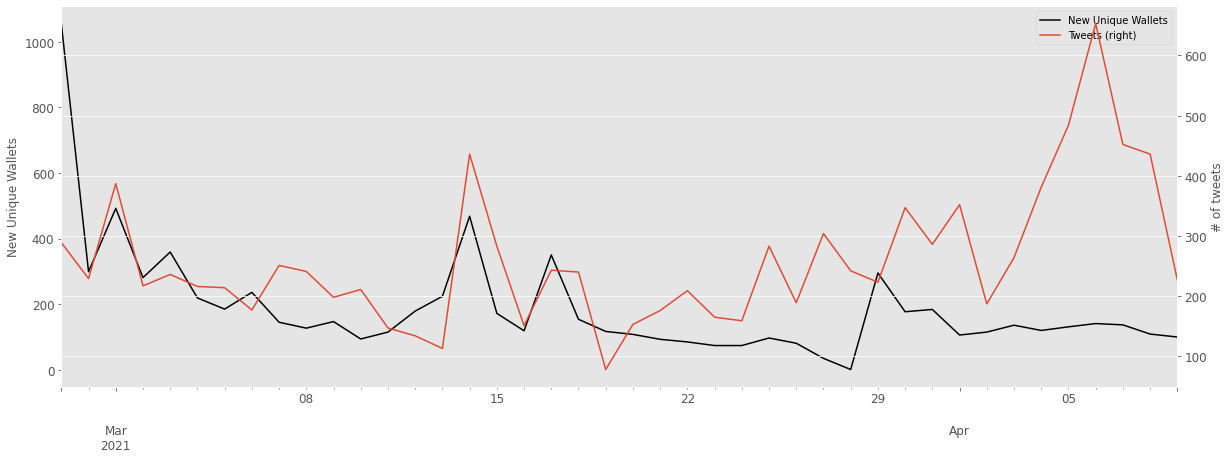

In [376]:
ax = tweets_vs_wallets.plot(y='New Unique Wallets', color='k')
ax.set_ylabel('New Unique Wallets')
ax2 = tweets_vs_wallets.plot(y='Tweets', ax=ax, secondary_y=True, figsize=(20,7), fontsize=12)
ax2.set_ylabel('# of tweets')
plt.show()

In [377]:
scipy.stats.pearsonr(tweets_vs_wallets['New Unique Wallets'], tweets_vs_wallets['Tweets'])

(0.13207902414833556, 0.4043938103780282)

In [378]:
statsmodels.tsa.stattools.grangercausalitytests(tweets_vs_wallets, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1379  , p=0.7124  , df_denom=38, df_num=1
ssr based chi2 test:   chi2=0.1488  , p=0.6997  , df=1
likelihood ratio test: chi2=0.1485  , p=0.6999  , df=1
parameter F test:         F=0.1379  , p=0.7124  , df_denom=38, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0218  , p=0.9784  , df_denom=35, df_num=2
ssr based chi2 test:   chi2=0.0499  , p=0.9753  , df=2
likelihood ratio test: chi2=0.0499  , p=0.9754  , df=2
parameter F test:         F=0.0218  , p=0.9784  , df_denom=35, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1959  , p=0.1077  , df_denom=32, df_num=3
ssr based chi2 test:   chi2=8.0289  , p=0.0454  , df=3
likelihood ratio test: chi2=7.3008  , p=0.0629  , df=3
parameter F test:         F=2.1959  , p=0.1077  , df_denom=32, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4151  , p=0.2538  , df_d

{1: ({'ssr_ftest': (0.13790895114245863, 0.7124312985747813, 38.0, 1),
   'ssr_chi2test': (0.14879649991686328, 0.6996881291707332, 1),
   'lrtest': (0.14852714655017962, 0.6999468618532017, 1),
   'params_ftest': (0.13790895114246451, 0.7124312985747728, 38.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.02184735938107122, 0.9784028972763011, 35.0, 2),
   'ssr_chi2test': (0.0499368214424485, 0.975340721851664, 2),
   'lrtest': (0.04990567628453846, 0.9753559105403262, 2),
   'params_ftest': (0.021847359381067296, 0.9784028972763049, 35.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.1959277297810655, 0.1077194207006019, 32.0, 3),
   'ssr_chi2test': (8.028860762012021, 0.04541899124103736, 3),
   'lrtest': (7.300793209697758, 0.06290401818445825, 3),
   'params_ftest': (2.195927729780984, 0.10771942070061179, 32.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.,

In [380]:
statsmodels.tsa.stattools.grangercausalitytests(tweets_vs_wallets.reindex(columns=['New Unique Wallets', 'Tweets']), maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0185  , p=0.1636  , df_denom=38, df_num=1
ssr based chi2 test:   chi2=2.1778  , p=0.1400  , df=1
likelihood ratio test: chi2=2.1219  , p=0.1452  , df=1
parameter F test:         F=2.0185  , p=0.1636  , df_denom=38, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7001  , p=0.1974  , df_denom=35, df_num=2
ssr based chi2 test:   chi2=3.8860  , p=0.1433  , df=2
likelihood ratio test: chi2=3.7086  , p=0.1566  , df=2
parameter F test:         F=1.7001  , p=0.1974  , df_denom=35, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0716  , p=0.3749  , df_denom=32, df_num=3
ssr based chi2 test:   chi2=3.9180  , p=0.2705  , df=3
likelihood ratio test: chi2=3.7334  , p=0.2917  , df=3
parameter F test:         F=1.0716  , p=0.3749  , df_denom=32, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4524  , p=0.7698  , df_d

{1: ({'ssr_ftest': (2.0184665619124704, 0.16355012894125567, 38.0, 1),
   'ssr_chi2test': (2.1778191852213493, 0.1400127354937602, 1),
   'lrtest': (2.12194892795344, 0.14520167073824752, 1),
   'params_ftest': (2.018466561912453, 0.16355012894125714, 38.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.7001041133721018, 0.1974027222466416, 35.0, 2),
   'ssr_chi2test': (3.885952259136233, 0.14327690399071888, 2),
   'lrtest': (3.7085928264411905, 0.15656305963089434, 2),
   'params_ftest': (1.700104113372148, 0.1974027222466332, 35.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.0715776656571026, 0.3749467235530451, 32.0, 3),
   'ssr_chi2test': (3.9179558400587813, 0.2704607891696182, 3),
   'lrtest': (3.7334170881770206, 0.29172640914471104, 3),
   'params_ftest': (1.0715776656571216, 0.3749467235530371, 32.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0